In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import KFold
import boto3
from io import StringIO

In [2]:
session = boto3.Session(profile_name='ai-dataset-bucket-readwrite-795524854110')

# Connect to S3
s3 = session.client('s3')

bucket_name = 'artificial-intelligence-datasets'
object_key = 'input/NIFTY50 Dataset/NIFTY50_all.csv'  # e.g., 'project1/data/sample.csv'

# Download object into memory
response = s3.get_object(Bucket=bucket_name, Key=object_key)

with response['Body'] as stream:
    body = stream.read().decode('utf-8')

df = pd.read_csv(StringIO(body))

df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741


In [3]:
df.shape

(235192, 15)

### Find the number of unique values in each attribute, so as to identify potential candidates for categorial variables

In [4]:
df.apply(pd.Series.nunique)

Date                    5306
Symbol                    65
Series                     1
Prev Close             63729
Open                   44298
High                   49036
Low                    51335
Last                   48570
Close                  63739
VWAP                  138831
Volume                220434
Turnover              235184
Trades                 79112
Deliverable Volume    199963
%Deliverble             9456
dtype: int64

#### Dropping the attribute series since the value seems to be the same for all records i.e. all this data is about equity.

In [5]:
df = df.drop(axis=1, columns=['Series'])

In [6]:
df.columns = ['Date', 'Symbol', 'Prev_Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'DeliverableVolume',
       'PercentageDeliverable']

### Verify if all attributes have been mapped to the correct data type

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   235192 non-null  object 
 1   Symbol                 235192 non-null  object 
 2   Prev_Close             235192 non-null  float64
 3   Open                   235192 non-null  float64
 4   High                   235192 non-null  float64
 5   Low                    235192 non-null  float64
 6   Last                   235192 non-null  float64
 7   Close                  235192 non-null  float64
 8   VWAP                   235192 non-null  float64
 9   Volume                 235192 non-null  int64  
 10  Turnover               235192 non-null  float64
 11  Trades                 120344 non-null  float64
 12  DeliverableVolume      219115 non-null  float64
 13  PercentageDeliverable  219115 non-null  float64
dtypes: float64(11), int64(1), object(2)


### Cast Date column to date data type

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Date                   235192 non-null  datetime64[ns]
 1   Symbol                 235192 non-null  object        
 2   Prev_Close             235192 non-null  float64       
 3   Open                   235192 non-null  float64       
 4   High                   235192 non-null  float64       
 5   Low                    235192 non-null  float64       
 6   Last                   235192 non-null  float64       
 7   Close                  235192 non-null  float64       
 8   VWAP                   235192 non-null  float64       
 9   Volume                 235192 non-null  int64         
 10  Turnover               235192 non-null  float64       
 11  Trades                 120344 non-null  float64       
 12  DeliverableVolume      219115 non-null  floa

### Demonstrate how df.query can be used to get records that meet certain conditions

In [10]:
df.query('PercentageDeliverable.isna()')

,Date,Symbol,Prev_Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,DeliverableVolume,PercentageDeliverable
3322,2000-01-03,ASIANPAINT,361.20,370.00,390.00,370.00,385.00,381.65,380.54,3318,1.262617e+11,NaN,NaN,NaN
3323,2000-01-04,ASIANPAINT,381.65,380.00,392.00,375.00,390.00,385.55,383.50,4818,1.847699e+11,NaN,NaN,NaN
3324,2000-01-05,ASIANPAINT,385.55,371.50,390.00,371.50,383.00,383.00,379.81,2628,9.981384e+10,NaN,NaN,NaN
3325,2000-01-06,ASIANPAINT,383.00,384.90,384.90,374.50,375.10,377.50,379.88,3354,1.274114e+11,NaN,NaN,NaN
3326,2000-01-07,ASIANPAINT,377.50,376.00,390.00,370.00,389.00,385.70,383.38,9589,3.676275e+11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231671,2007-02-12,ZEETELE,361.30,225.25,319.40,225.25,257.00,258.35,265.73,4429894,1.177153e+14,NaN,NaN,NaN
231672,2007-02-13,ZEETELE,258.35,260.00,276.95,252.25,272.55,267.95,269.91,2689950,7.260378e+13,NaN,NaN,NaN
231673,2007-02-14,ZEETELE,267.95,272.00,277.00,256.50,265.50,265.50,263.25,2820444,7.424754e+13,NaN,NaN,NaN
231674,2007-02-15,ZEETELE,265.50,269.90,273.50,265.10,268.00,268.25,268.78,3516748,9.452372e+13,NaN,NaN,NaN


In [11]:
df.query('Volume > 300000')

,Date,Symbol,Prev_Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,DeliverableVolume,PercentageDeliverable
0,2007-11-27,MUNDRAPORT,440.00,770.00,1050.00,770.00,959.00,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612
1,2007-11-28,MUNDRAPORT,962.90,984.00,990.00,874.00,885.00,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172
2,2007-11-29,MUNDRAPORT,893.90,909.00,914.75,841.00,887.00,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088
3,2007-11-30,MUNDRAPORT,884.20,890.00,958.00,890.00,929.00,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735
4,2007-12-03,MUNDRAPORT,921.55,939.75,995.00,922.00,980.00,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235187,2021-04-26,ZEEL,188.00,190.60,191.10,185.10,186.70,186.40,187.35,8542755,1.600451e+14,52374.0,2340188.0,0.2739
235188,2021-04-27,ZEEL,186.40,188.00,192.95,186.80,188.80,188.15,189.41,14247767,2.698636e+14,73673.0,5425957.0,0.3808
235189,2021-04-28,ZEEL,188.15,188.80,190.60,187.10,188.95,189.10,188.85,8429439,1.591917e+14,44056.0,2413974.0,0.2864
235190,2021-04-29,ZEEL,189.10,190.80,191.65,186.00,186.60,186.55,187.44,9483009,1.777471e+14,60932.0,2744472.0,0.2894


### Replace null values in trades attribute with 0

In [12]:
df['DeliverableVolume'] = df.groupby('Symbol')['DeliverableVolume'].transform(lambda x: x.fillna(x.mean()))

In [13]:
df.fillna({'Trades': 0.0}, inplace=True)

### Encoding Symbol

In [14]:
df['Symbol'].value_counts()

Symbol
IOC           5306
CIPLA         5306
M&M           5306
ICICIBANK     5306
ONGC          5306
              ... 
MUNDRAPORT    1023
TELCO          999
KOTAKMAH       502
SSLT           388
JSWSTL         123
Name: count, Length: 65, dtype: int64

In [15]:
df['Symbol_en'] = np.nan

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
for train_idx, val_idx in kf.split(df):
   training_set = df.iloc[train_idx]
   company_mean = training_set.groupby('Symbol')['Open'].mean()
   overall_mean = training_set['Open'].mean()
   training_set_value_counts = training_set['Symbol'].value_counts()


   df.loc[val_idx, 'Symbol_en'] = df.loc[val_idx, 'Symbol'].map(lambda company_name : \
             (((company_mean.get(company_name, overall_mean) * training_set_value_counts.get(company_name, 0) + \
                (overall_mean * training_set.shape[0])) / \
                training_set_value_counts.get(company_name, 0) + training_set.shape[0])))


### Drop Percentage Deliverable since it provides the same information as Deliverable Volume but in a % format

In [18]:
df.drop(axis=1, columns=['PercentageDeliverable'], inplace=True)

### Analyze the data

In [19]:
df.describe()

,Date,Prev_Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,DeliverableVolume,Symbol_en
count,235192,235192.000000,235192.000000,235192.000000,235192.000000,235192.000000,235192.000000,235192.00000,2.351920e+05,2.351920e+05,2.351920e+05,2.351920e+05,2.351920e+05
mean,2011-05-22 13:18:08.975815680,1266.196349,1267.759708,1286.581440,1247.488465,1266.388302,1266.554351,1267.13230,3.045903e+06,1.610138e+14,3.170613e+04,1.299118e+06,2.718913e+05
min,2000-01-03 00:00:00,0.000000,8.500000,9.750000,8.500000,9.100000,9.150000,9.21000,3.000000e+00,1.047000e+07,0.000000e+00,5.000000e+00,2.439414e+05
25%,2006-07-03 00:00:00,274.300000,275.000000,279.500000,269.600000,274.400000,274.350000,274.69750,2.190095e+05,1.612816e+13,0.000000e+00,1.350515e+05,2.453699e+05
50%,2011-08-19 00:00:00,566.500000,567.025000,576.900000,556.500000,567.000000,566.700000,566.94000,1.010938e+06,6.832603e+13,1.768500e+03,5.339250e+05,2.546561e+05
75%,2016-06-24 00:00:00,1242.200000,1243.312500,1263.000000,1221.650000,1242.900000,1242.400000,1242.66250,3.019851e+06,1.863835e+14,4.528125e+04,1.424938e+06,2.761599e+05
max,2021-04-30 00:00:00,32861.950000,33399.950000,33480.000000,32468.100000,32849.000000,32861.950000,32975.24000,4.810589e+08,3.564334e+16,1.643015e+06,2.325307e+08,2.836632e+06
std,NaN,2581.370320,2585.259609,2619.649216,2546.621396,2581.392543,2582.140942,2582.69998,7.333981e+06,3.298085e+14,5.806774e+04,2.749086e+06,7.625495e+04


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               235192 non-null  datetime64[ns]
 1   Symbol             235192 non-null  object        
 2   Prev_Close         235192 non-null  float64       
 3   Open               235192 non-null  float64       
 4   High               235192 non-null  float64       
 5   Low                235192 non-null  float64       
 6   Last               235192 non-null  float64       
 7   Close              235192 non-null  float64       
 8   VWAP               235192 non-null  float64       
 9   Volume             235192 non-null  int64         
 10  Turnover           235192 non-null  float64       
 11  Trades             235192 non-null  float64       
 12  DeliverableVolume  235192 non-null  float64       
 13  Symbol_en          235192 non-null  float64 

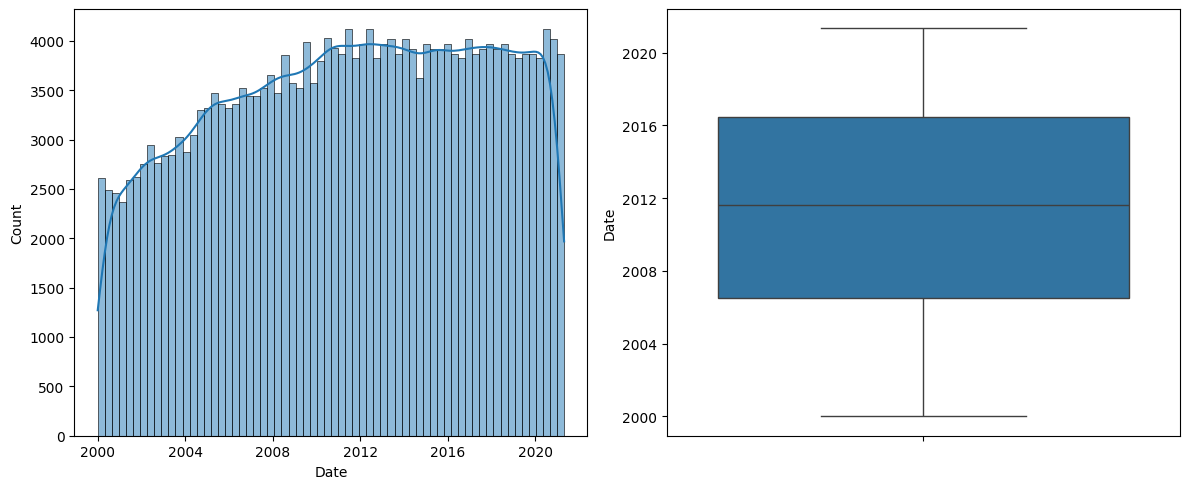

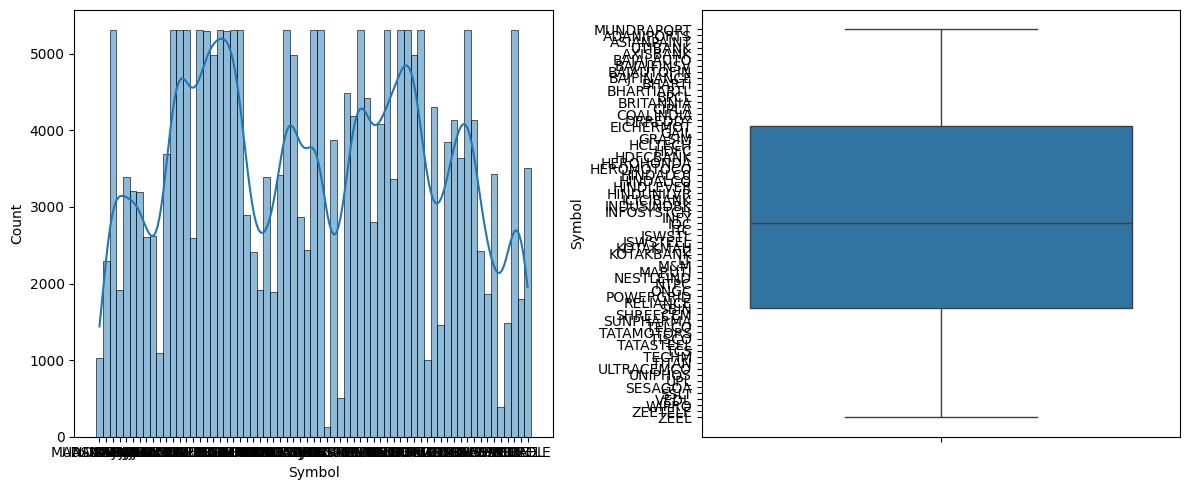

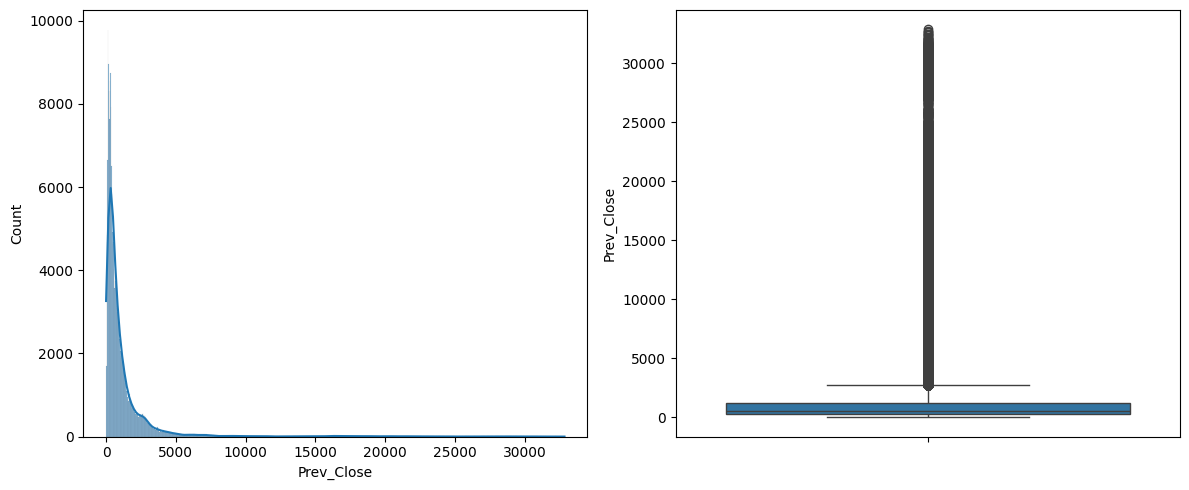

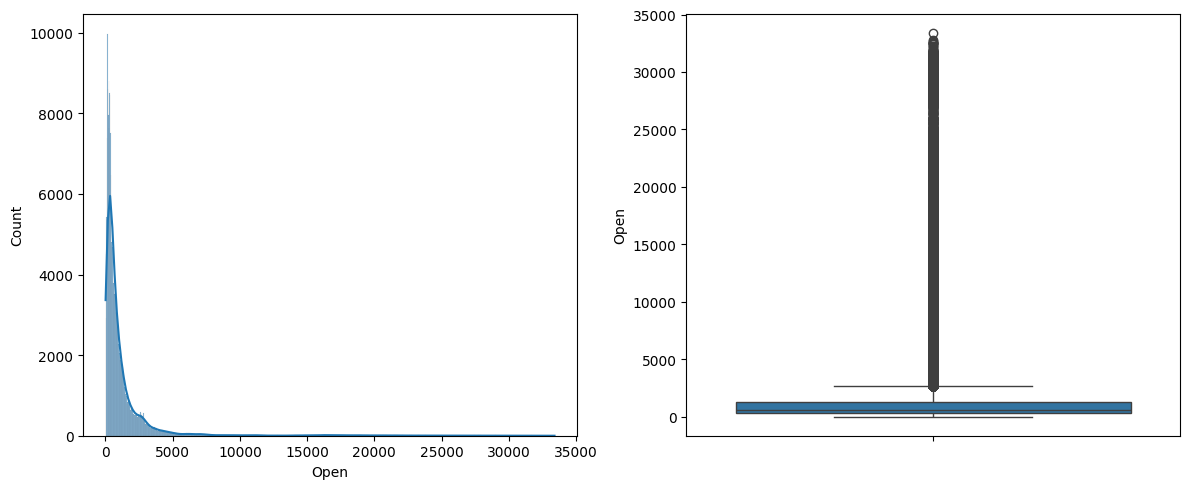

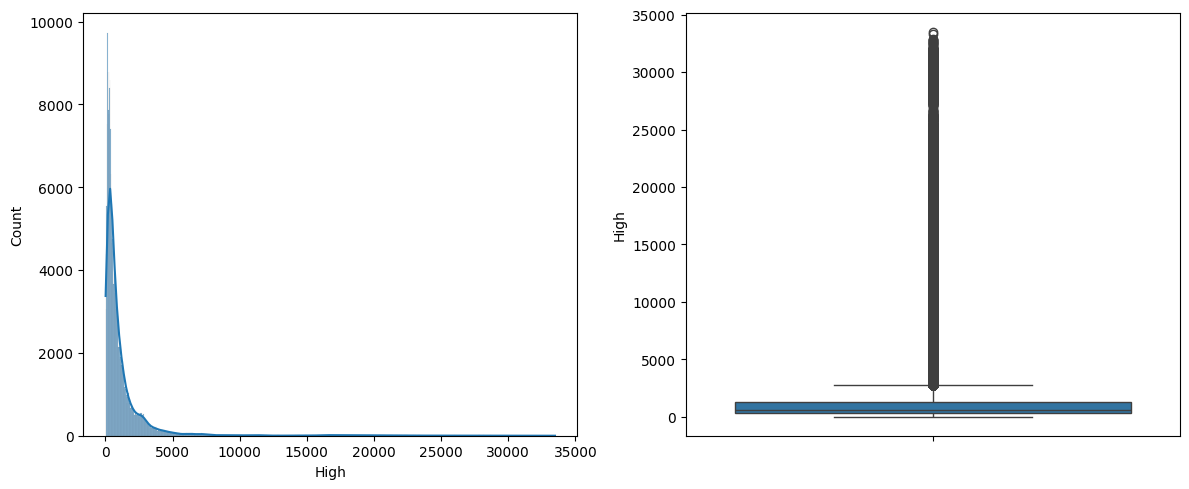

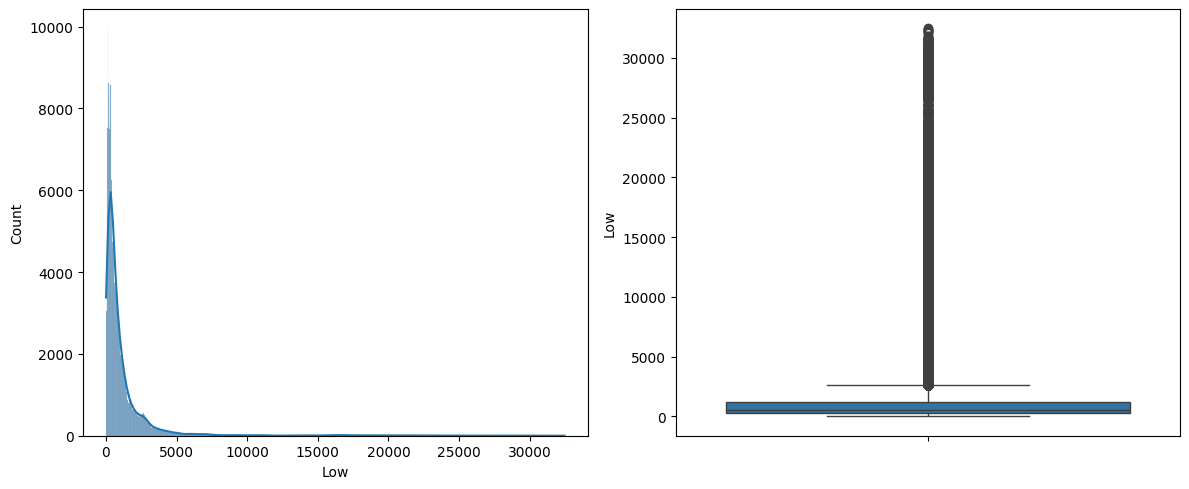

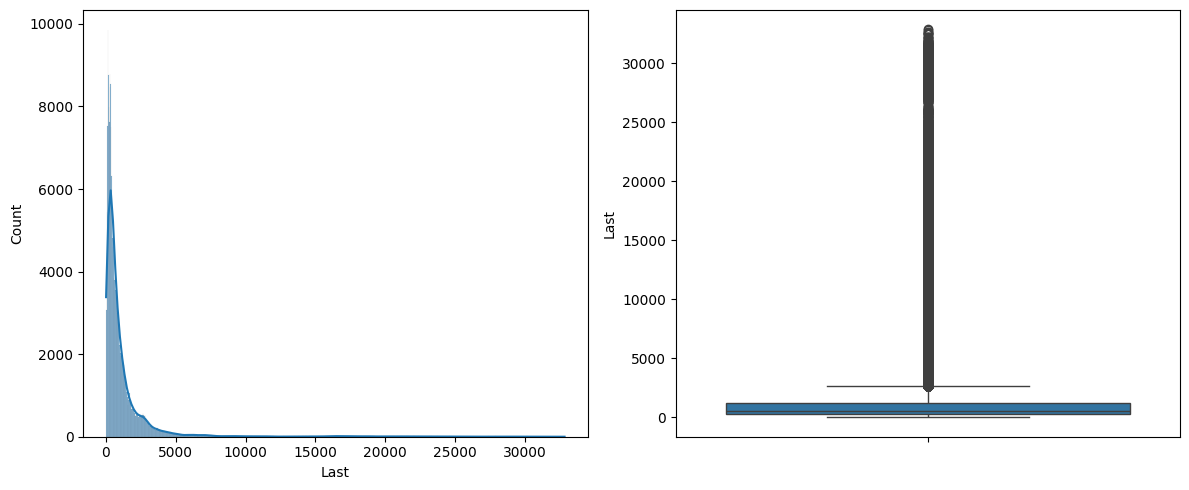

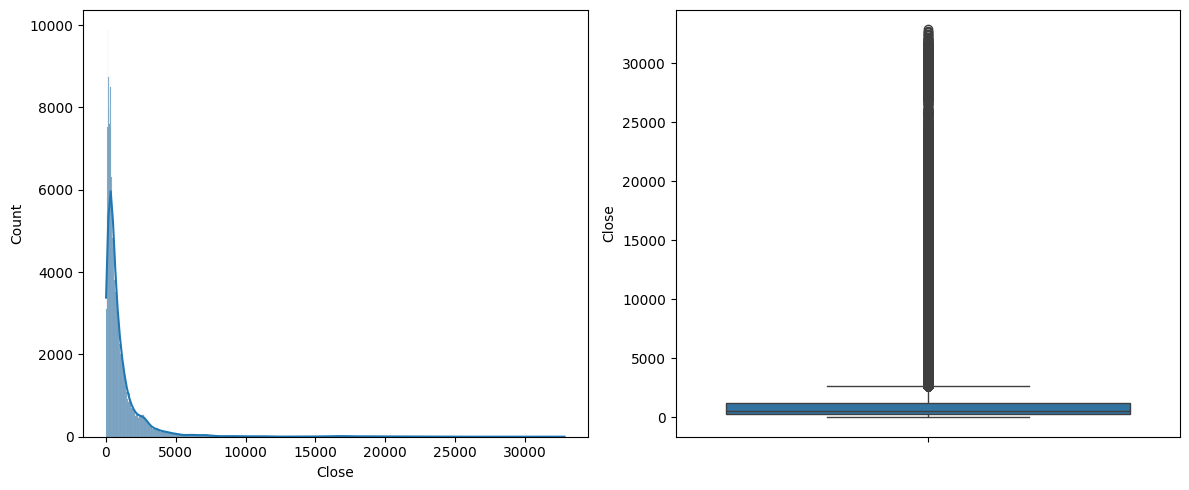

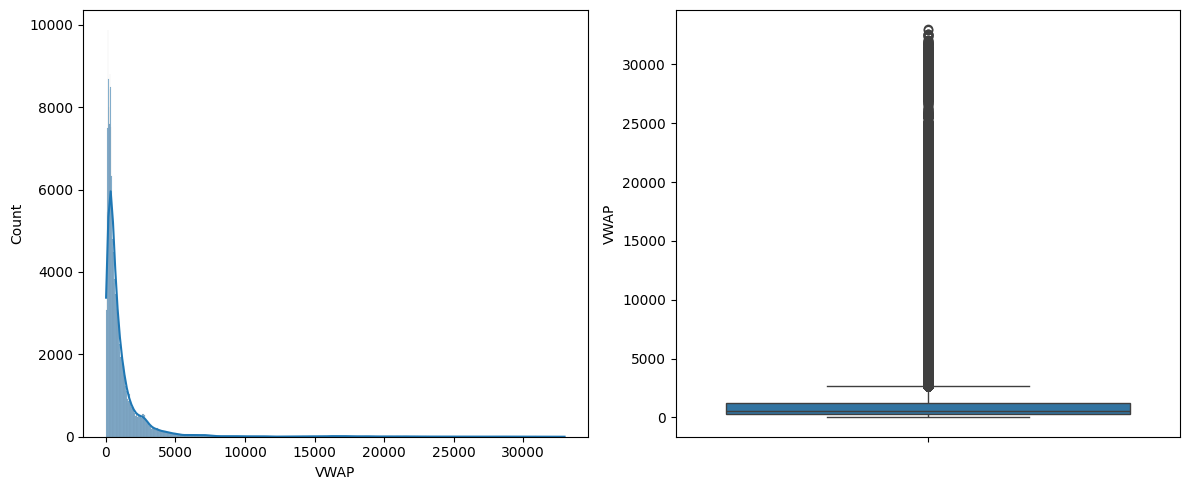

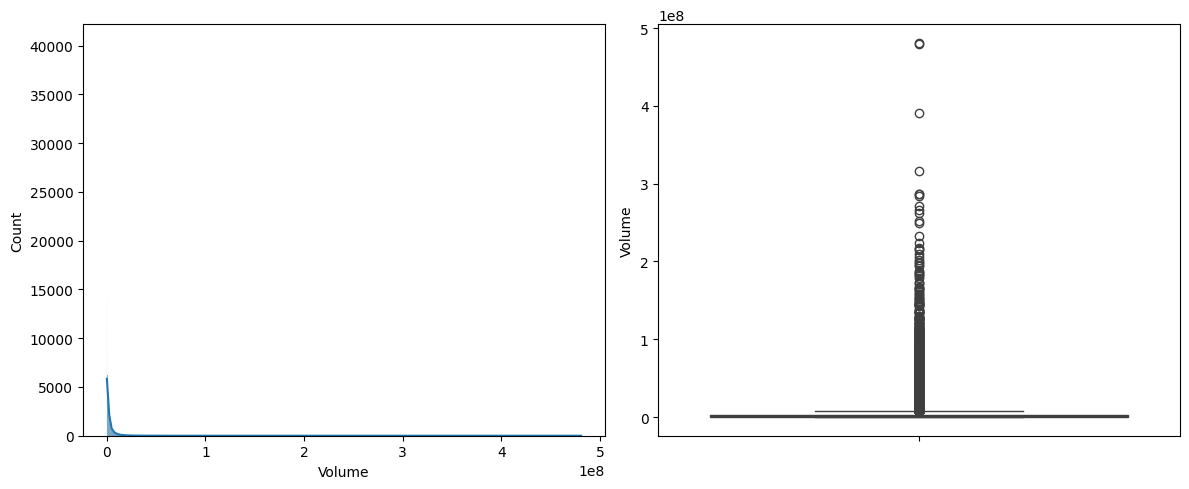

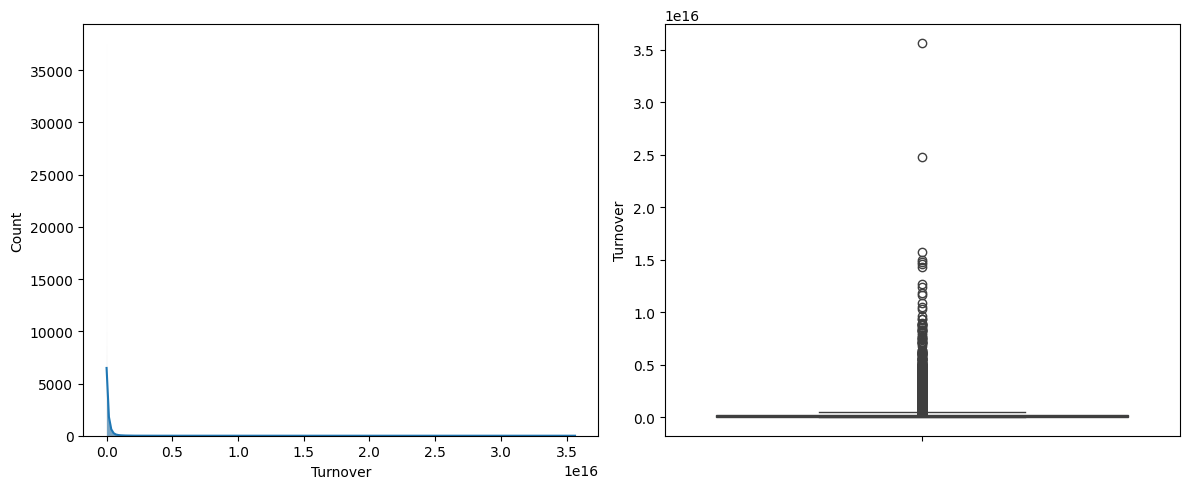

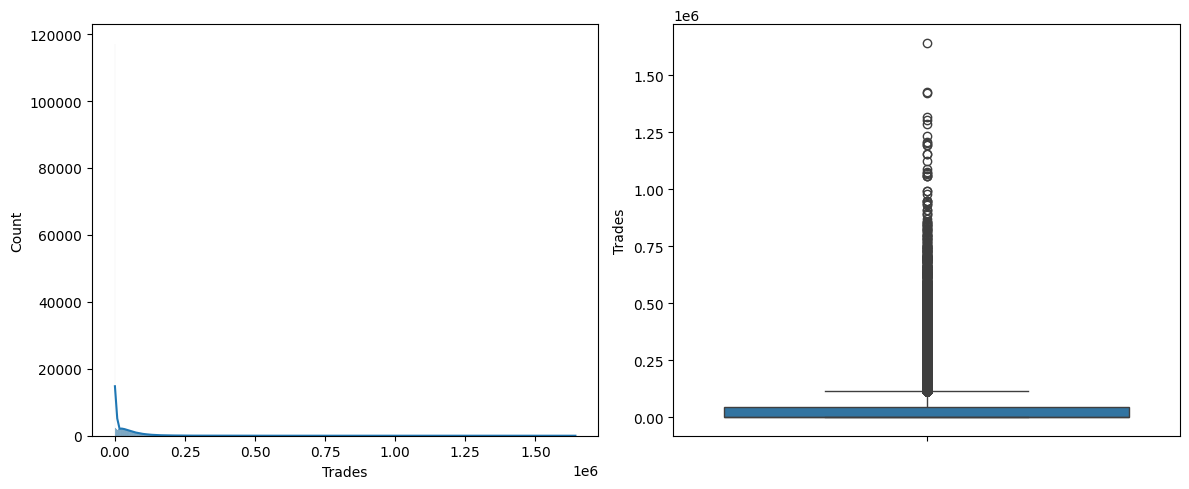

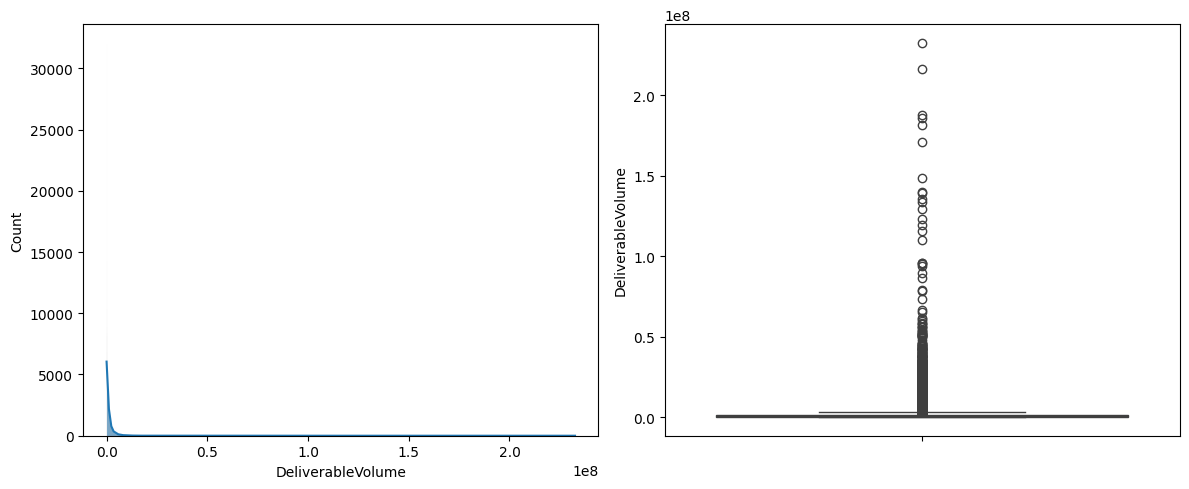

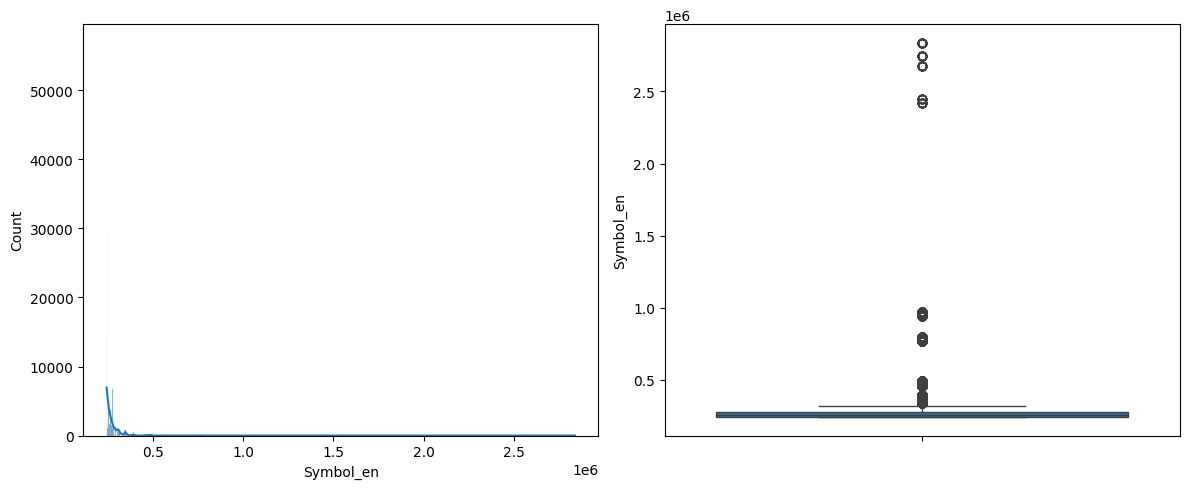

In [21]:
for col in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(df[col], ax=axes[1])
    plt.tight_layout()
    plt.show()

In [22]:
scalar = RobustScaler()

for col in df.columns:
    if col not in ['Date', 'Symbol']:
        df[f"{col}_scaled"] = scalar.fit_transform(df[[col]])

In [23]:
df.head()

,Date,Symbol,Prev_Close,Open,High,Low,Last,Close,VWAP,Volume,...,High_scaled,Low_scaled,Last_scaled,Close_scaled,VWAP_scaled,Volume_scaled,Turnover_scaled,Trades_scaled,DeliverableVolume_scaled,Symbol_en_scaled
0,2007-11-27,MUNDRAPORT,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,...,0.481037,0.224253,0.404750,0.409276,0.431607,9.384118,15.385090,-0.039056,7.229856,7.441885
1,2007-11-28,MUNDRAPORT,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,...,0.420031,0.333491,0.328343,0.337999,0.386832,1.274760,2.131802,-0.039056,0.712739,7.255762
2,2007-11-29,MUNDRAPORT,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,...,0.343518,0.298829,0.330408,0.327979,0.331779,1.468552,2.271529,-0.039056,0.415349,7.244327
3,2007-11-30,MUNDRAPORT,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,...,0.387494,0.350297,0.373774,0.366562,0.374218,1.284908,2.114470,-0.039056,0.563606,7.255762
4,2007-12-03,MUNDRAPORT,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,...,0.425114,0.383908,0.426433,0.415888,0.411905,0.702122,1.287443,-0.039056,0.218777,7.470765


### Split Date

In [24]:
df = df.copy()
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.day_of_week
df['Day_of_Year'] = df['Date'].dt.day_of_year

In [25]:
df.columns

Index(['Date', 'Symbol', 'Prev_Close', 'Open', 'High', 'Low', 'Last', 'Close',
       'VWAP', 'Volume', 'Turnover', 'Trades', 'DeliverableVolume',
       'Symbol_en', 'Prev_Close_scaled', 'Open_scaled', 'High_scaled',
       'Low_scaled', 'Last_scaled', 'Close_scaled', 'VWAP_scaled',
       'Volume_scaled', 'Turnover_scaled', 'Trades_scaled',
       'DeliverableVolume_scaled', 'Symbol_en_scaled', 'Year', 'Month', 'Day',
       'Day_of_Week', 'Day_of_Year'],
      dtype='object')

In [26]:
clean_df = df.filter(regex='_scaled$|^Date$|^Year$|^Month$|^Day$|^Day_of_Week$|^Day_of_Year$|^Symbol|^Close$', axis=1)
clean_df.head()

,Date,Symbol,Close,Symbol_en,Prev_Close_scaled,Open_scaled,High_scaled,Low_scaled,Last_scaled,Close_scaled,...,Volume_scaled,Turnover_scaled,Trades_scaled,DeliverableVolume_scaled,Symbol_en_scaled,Year,Month,Day,Day_of_Week,Day_of_Year
0,2007-11-27,MUNDRAPORT,962.90,483791.136313,-0.130695,0.209617,0.481037,0.224253,0.404750,0.409276,...,9.384118,15.385090,-0.039056,7.229856,7.441885,2007,11,27,1,331
1,2007-11-28,MUNDRAPORT,893.90,478060.423240,0.409546,0.430620,0.420031,0.333491,0.328343,0.337999,...,1.274760,2.131802,-0.039056,0.712739,7.255762,2007,11,28,2,332
2,2007-11-29,MUNDRAPORT,884.20,477708.343281,0.338258,0.353166,0.343518,0.298829,0.330408,0.327979,...,1.468552,2.271529,-0.039056,0.415349,7.244327,2007,11,29,3,333
3,2007-11-30,MUNDRAPORT,921.55,478060.423240,0.328236,0.333544,0.387494,0.350297,0.373774,0.366562,...,1.284908,2.114470,-0.039056,0.563606,7.255762,2007,11,30,4,334
4,2007-12-03,MUNDRAPORT,969.30,484680.351304,0.366825,0.384922,0.425114,0.383908,0.426433,0.415888,...,0.702122,1.287443,-0.039056,0.218777,7.470765,2007,12,3,0,337


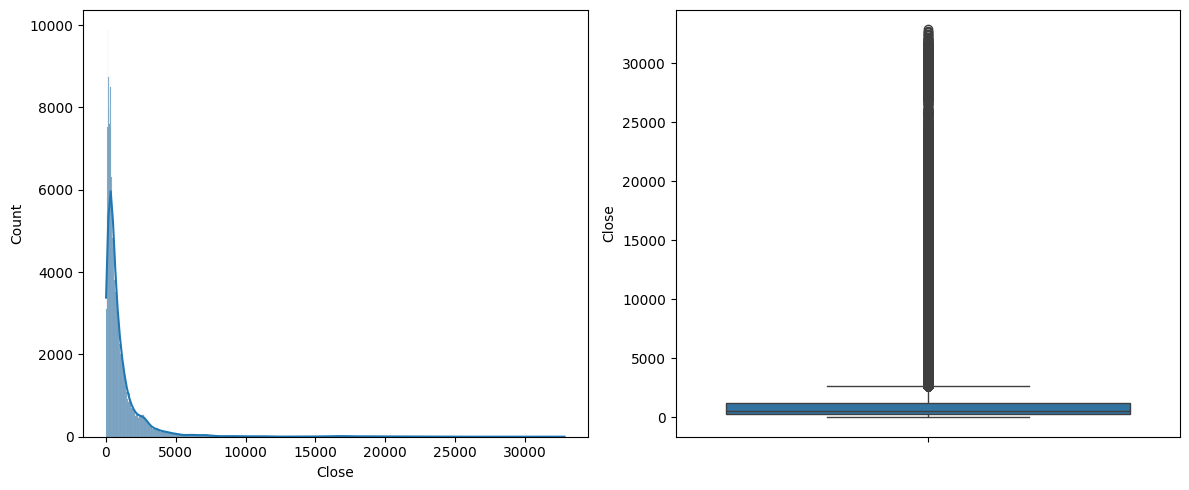

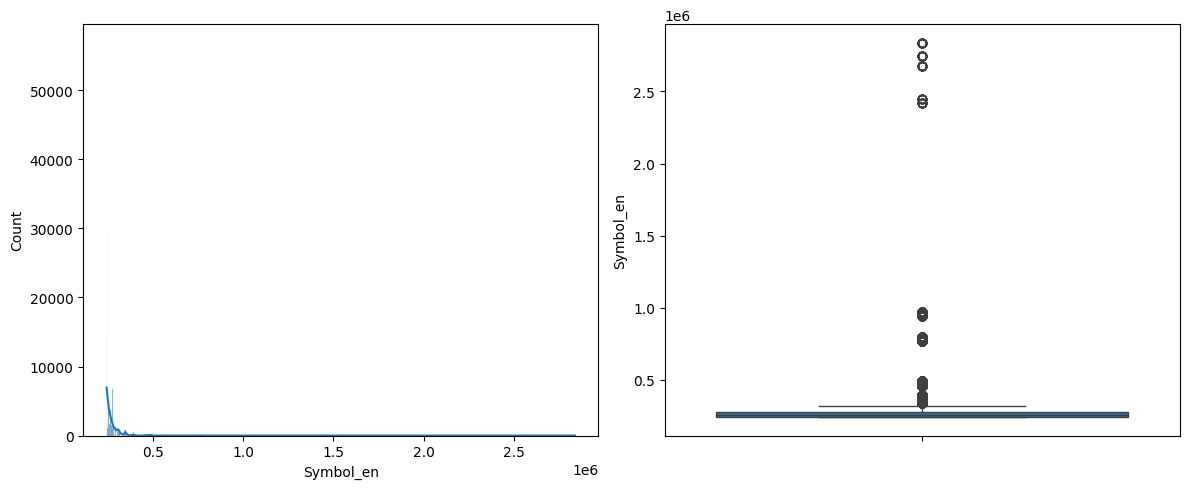

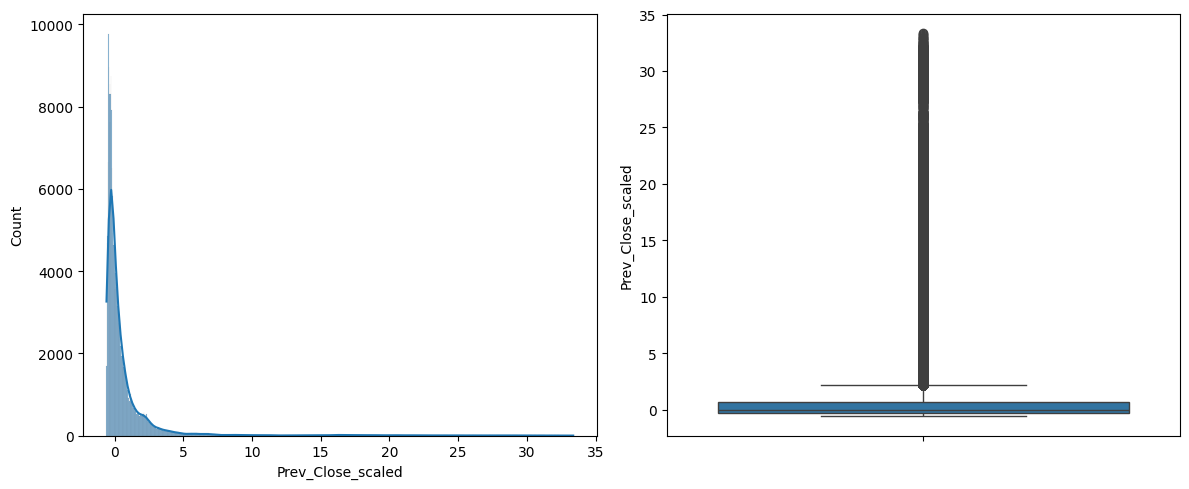

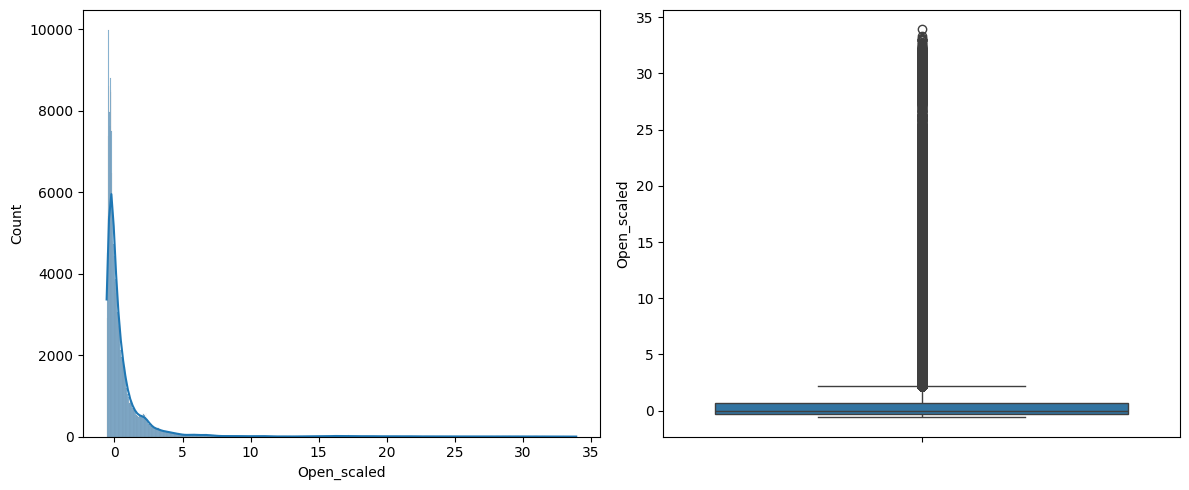

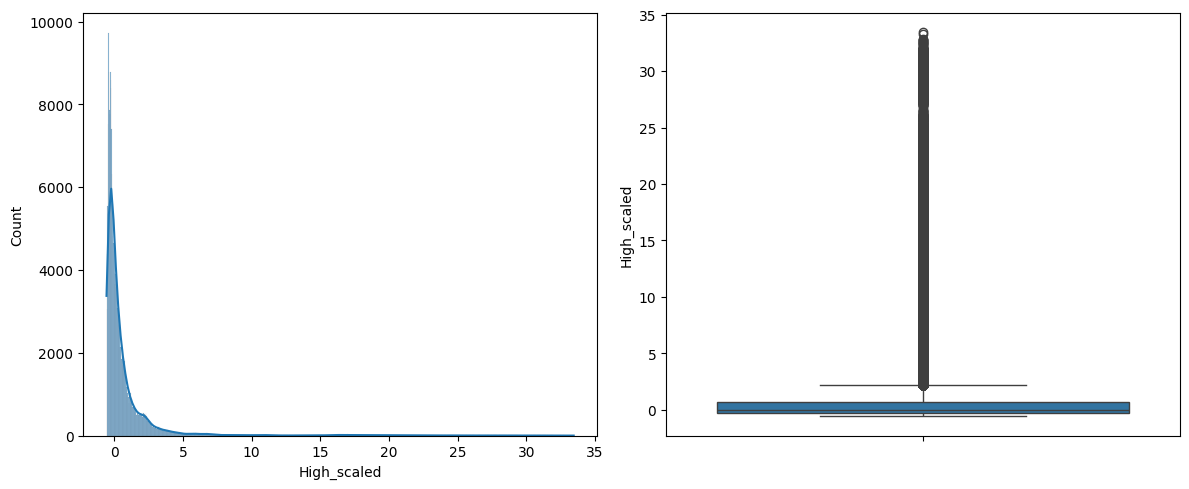

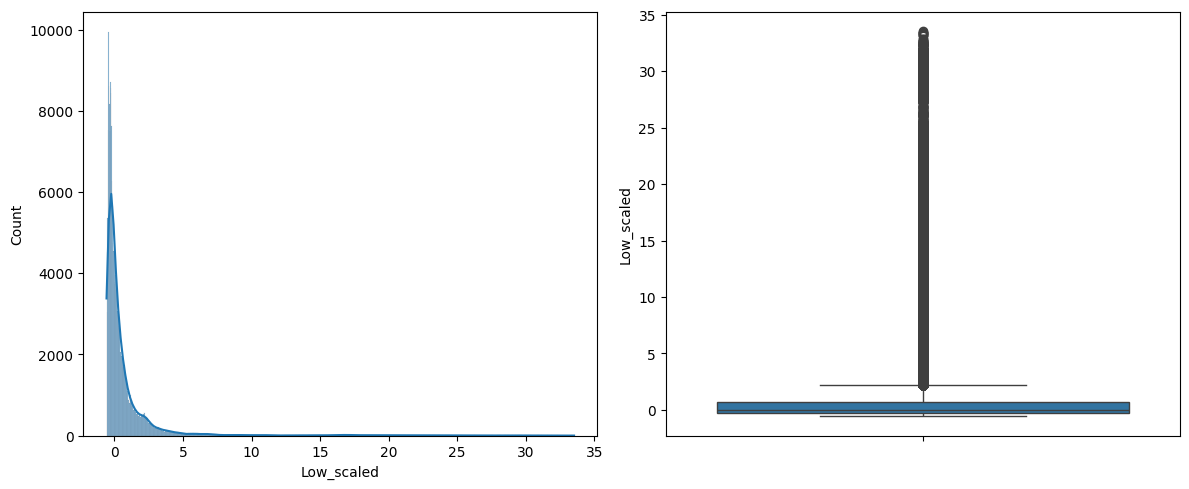

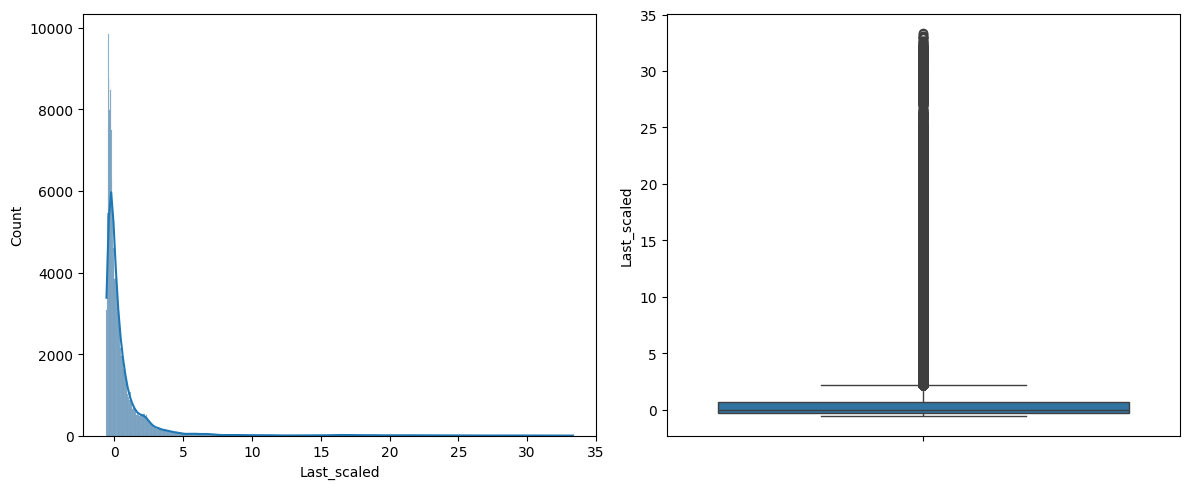

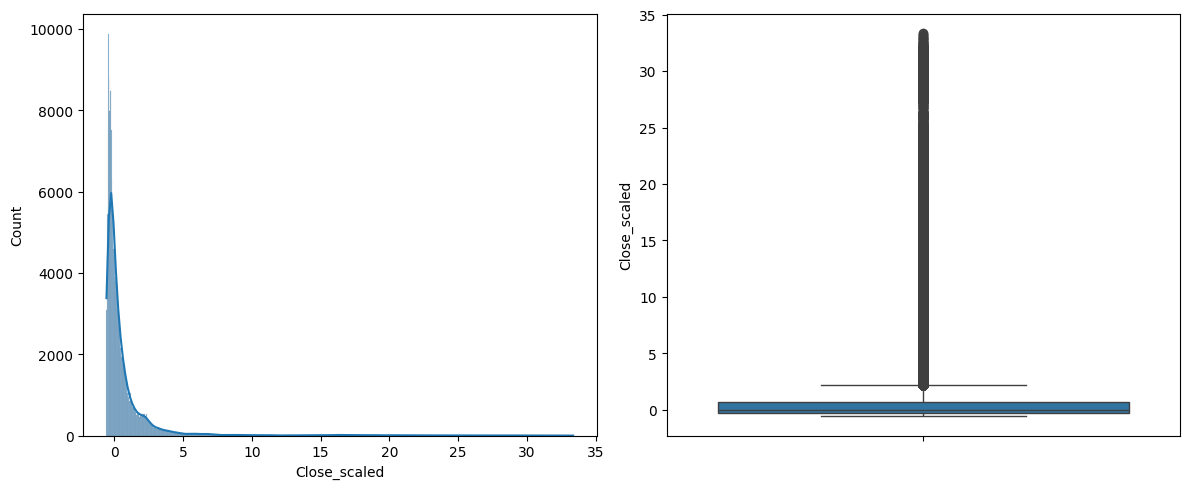

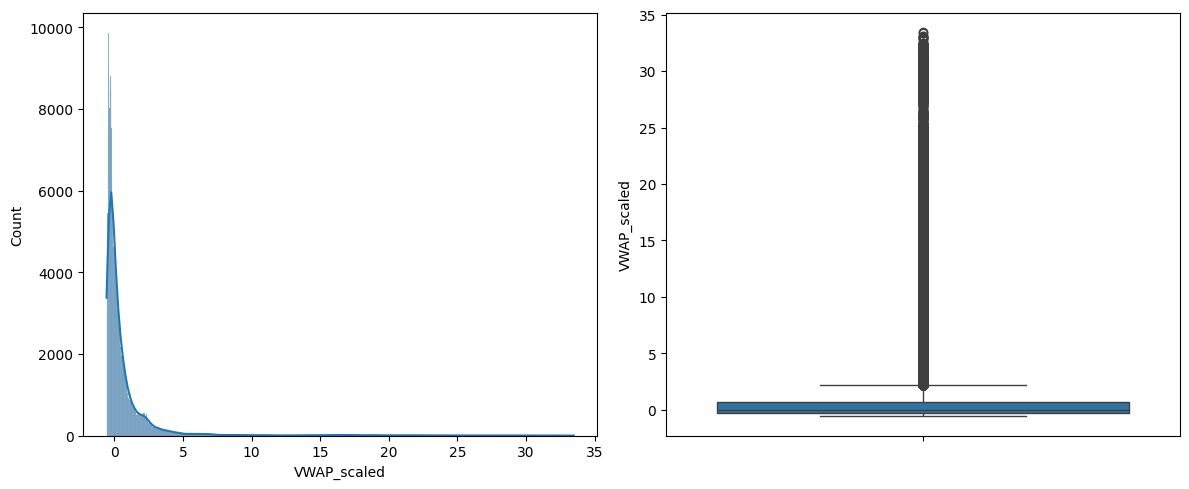

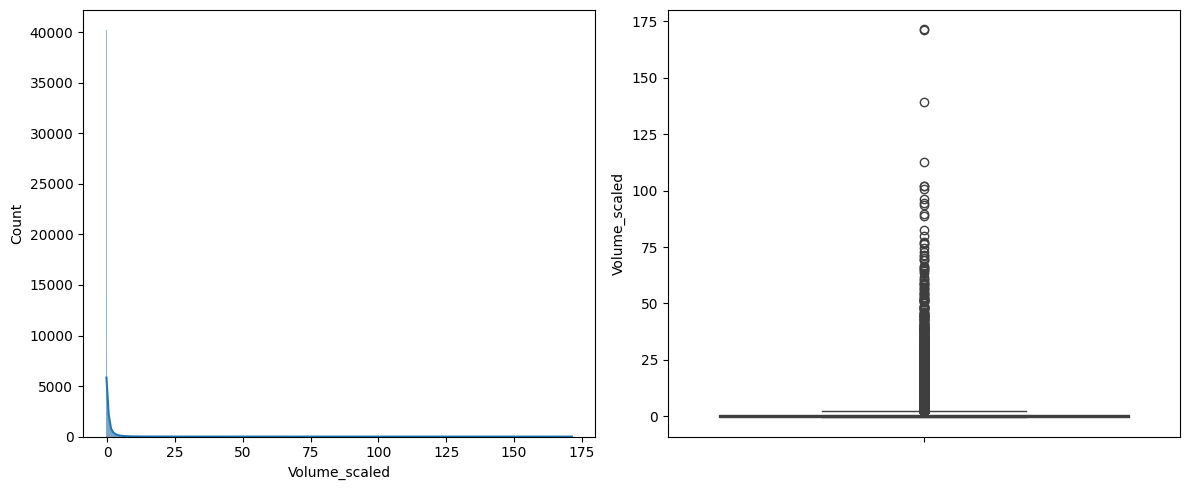

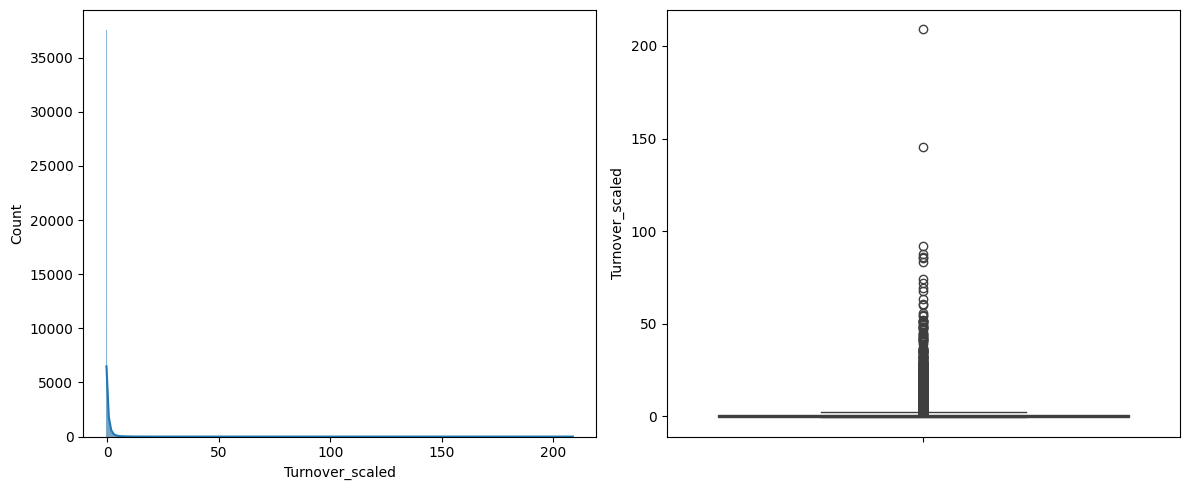

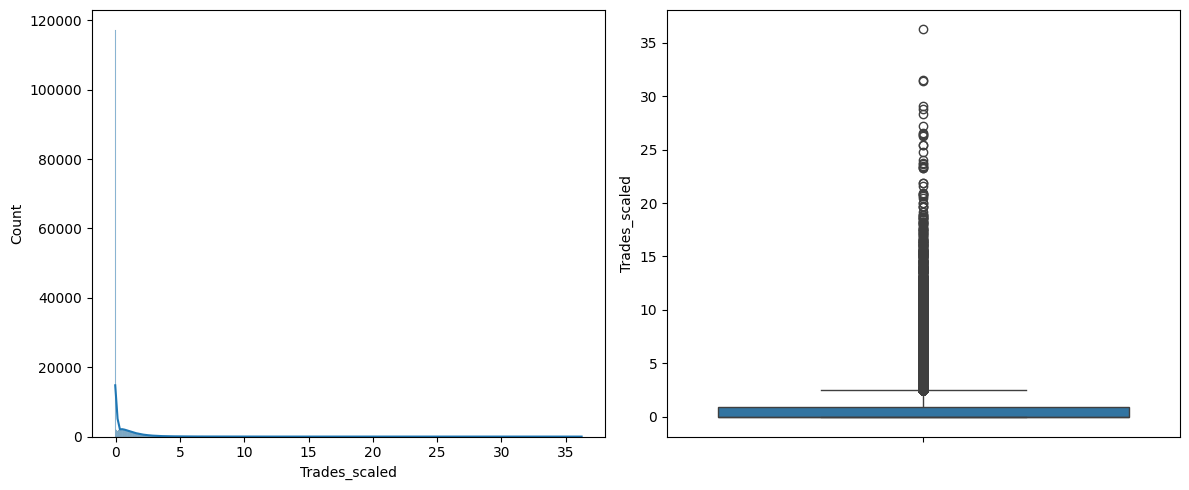

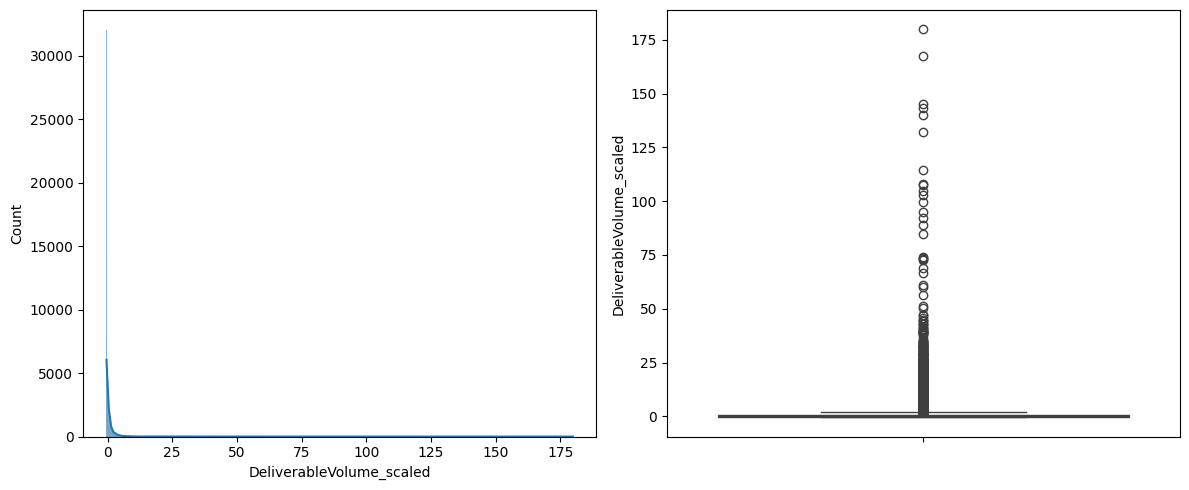

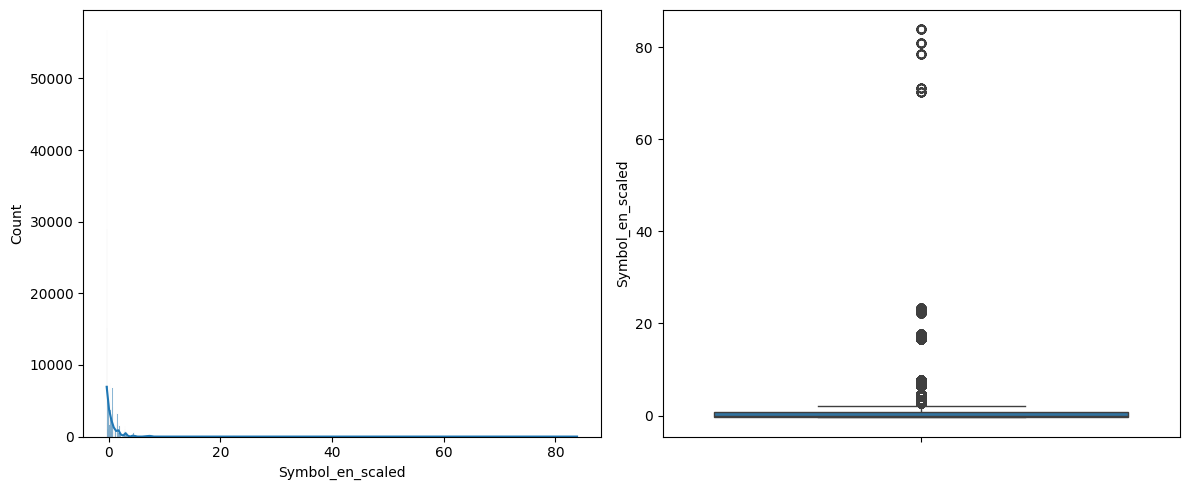

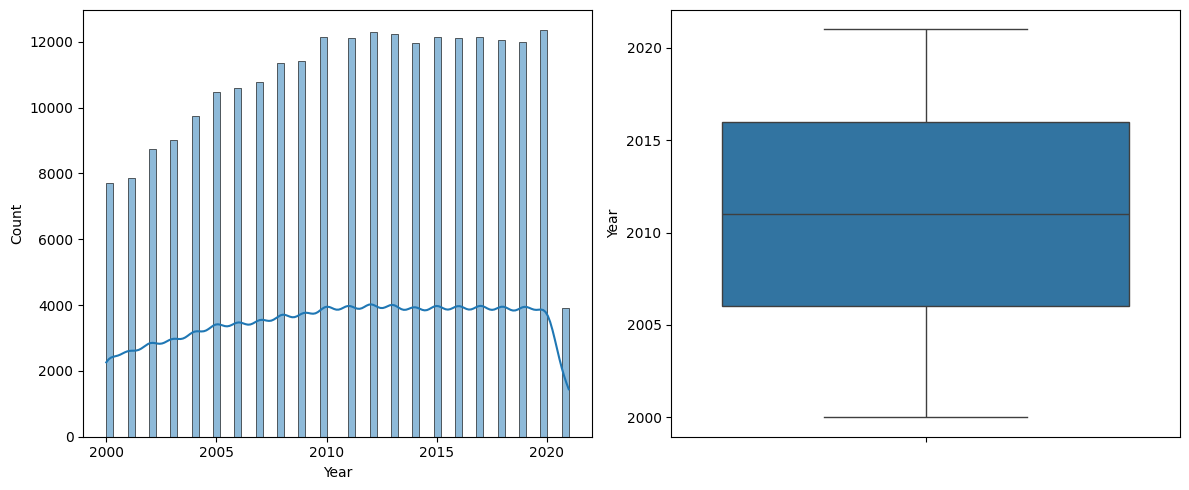

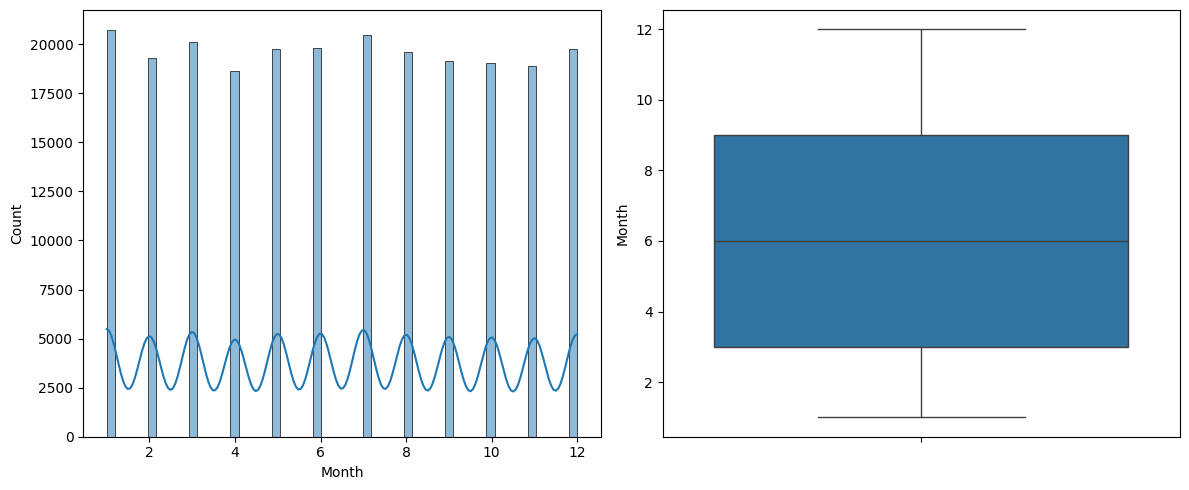

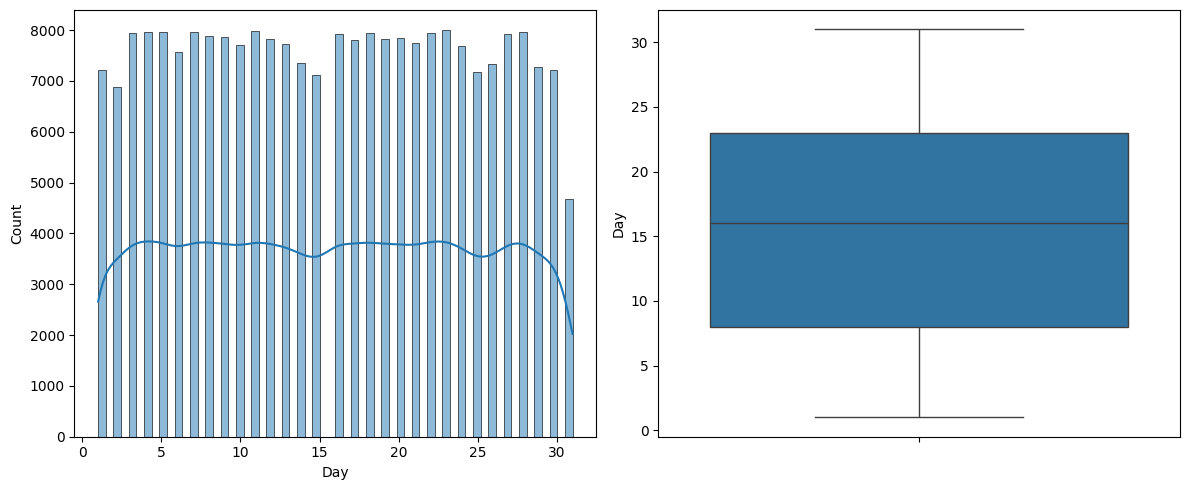

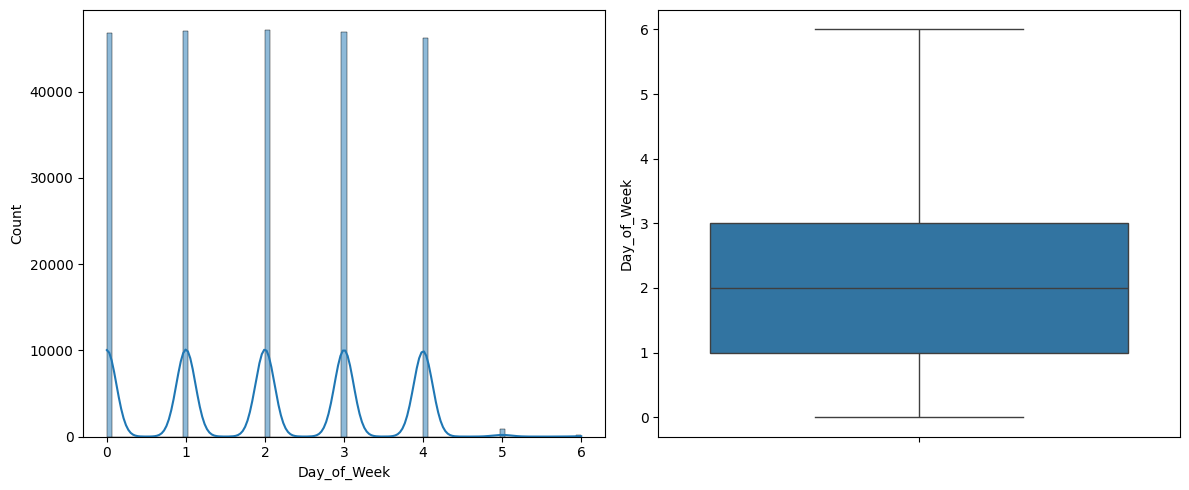

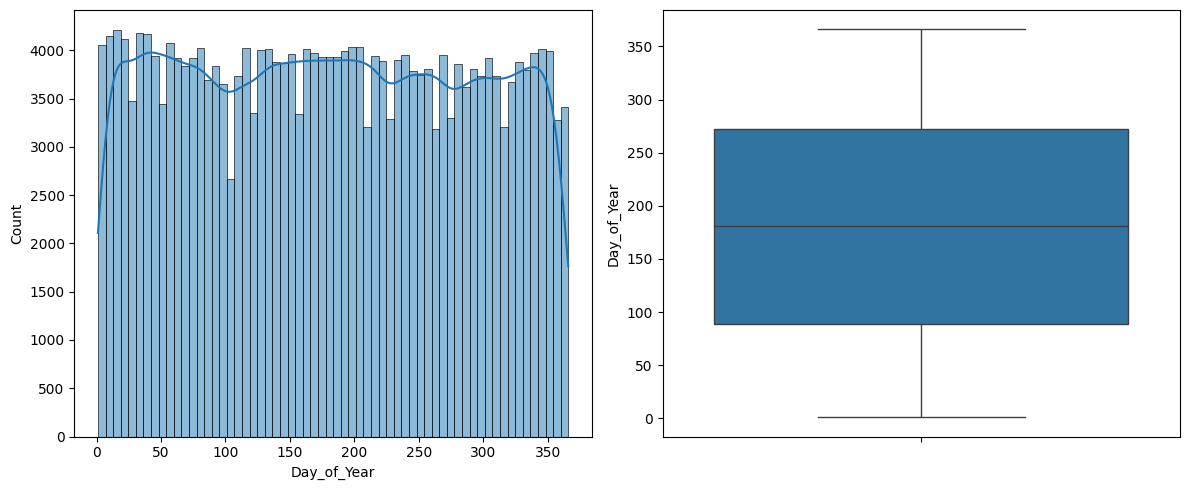

In [27]:
for col in clean_df.columns:
    if col != 'Date' and col != 'Symbol':
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.histplot(clean_df[col], kde=True, ax=axes[0])
        sns.boxplot(clean_df[col], ax=axes[1])
        plt.tight_layout()
        plt.show()

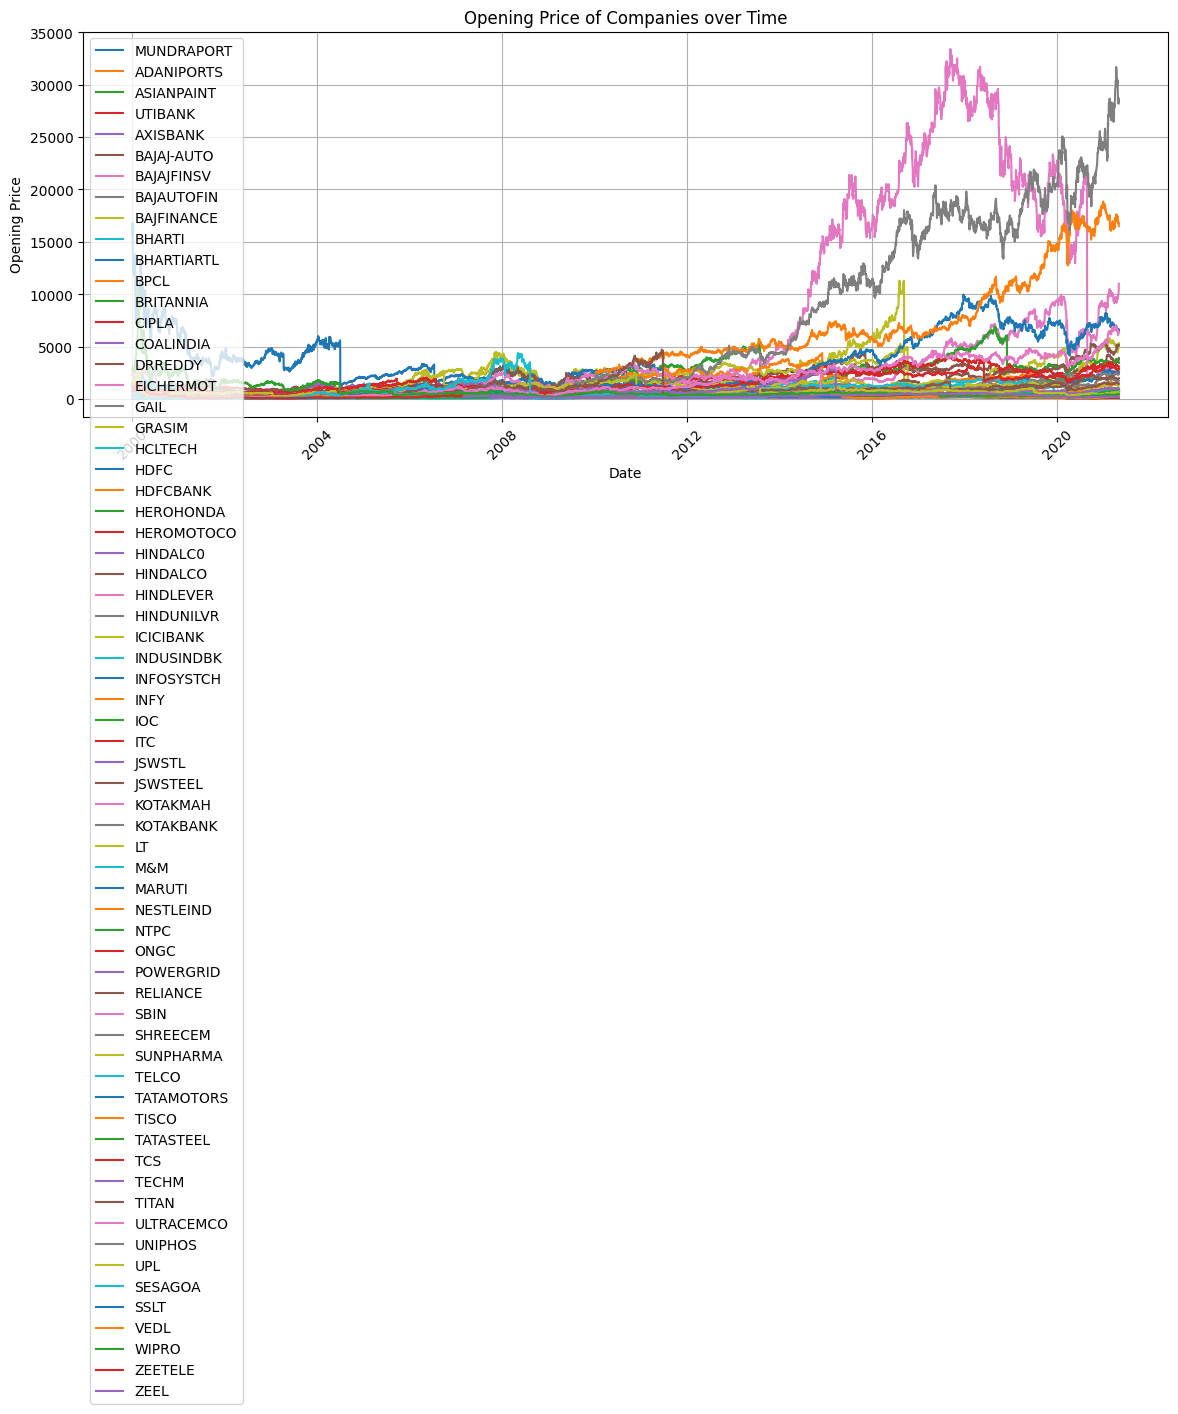

In [28]:
companies = clean_df['Symbol'].unique()

plt.figure(figsize=(14, 5))

for company in companies:
    subset = df.query(f"Symbol == '{company}'")
    sns.lineplot(data=subset, x='Date', y='Open', label=company)

plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.title('Opening Price of Companies over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


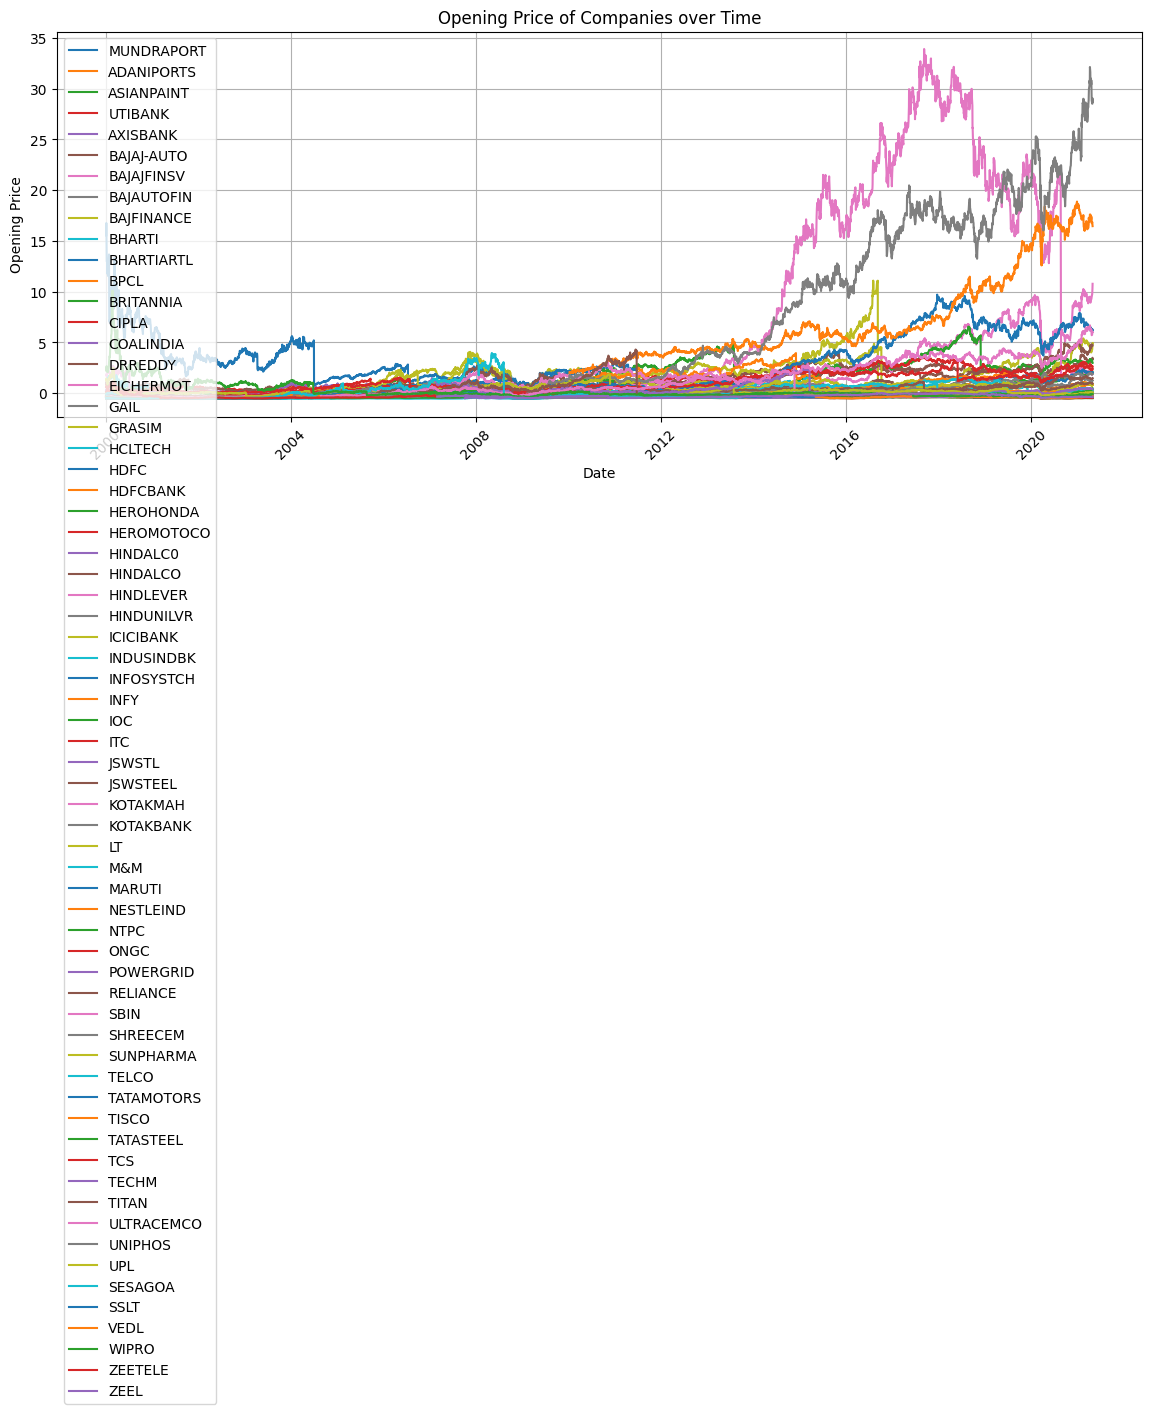

In [29]:
companies = clean_df['Symbol'].unique()

plt.figure(figsize=(14, 5))

for company in companies:
    subset = clean_df.query(f"Symbol == '{company}'")
    sns.lineplot(data=subset, x='Date', y='Open_scaled', label=company)

plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.title('Opening Price of Companies over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [30]:
clean_df['Symbol'].unique()

array(['MUNDRAPORT', 'ADANIPORTS', 'ASIANPAINT', 'UTIBANK', 'AXISBANK',
       'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJAUTOFIN', 'BAJFINANCE', 'BHARTI',
       'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DRREDDY',
       'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH', 'HDFC', 'HDFCBANK',
       'HEROHONDA', 'HEROMOTOCO', 'HINDALC0', 'HINDALCO', 'HINDLEVER',
       'HINDUNILVR', 'ICICIBANK', 'INDUSINDBK', 'INFOSYSTCH', 'INFY',
       'IOC', 'ITC', 'JSWSTL', 'JSWSTEEL', 'KOTAKMAH', 'KOTAKBANK', 'LT',
       'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'POWERGRID',
       'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA', 'TELCO', 'TATAMOTORS',
       'TISCO', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UNIPHOS', 'UPL', 'SESAGOA', 'SSLT', 'VEDL', 'WIPRO', 'ZEETELE',
       'ZEEL'], dtype=object)

In [31]:
companies = clean_df['Symbol'].unique()

# Function to update plot
def upload_plot(selected_company):
    plt.clf()

    plt.figure(figsize=(14, 5))

    # Filter data for selected company
    subset = clean_df[clean_df["Symbol"] == selected_company]

    # Plot the stock trend
    sns.lineplot(data=subset, x='Date', y='Open_scaled', label="Opening Price")
    sns.lineplot(data=subset, x='Date', y='Close_scaled', label="Closing Price")
    sns.lineplot(data=subset, x='Date', y='Prev_Close_scaled', label="Previous Closing Price")

    plt.xlabel('Date')
    plt.ylabel('Stock Prices')
    plt.title(f'Opening Price of {selected_company} over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# Create Dropdown Widget
dropdown = widgets.Dropdown(
    options=companies,
    description='Company:',
    disabled=False
)

# Display widgets properly
display(dropdown, widgets.interactive_output(upload_plot, {'selected_company': dropdown}))

Dropdown(description='Company:', options=('MUNDRAPORT', 'ADANIPORTS', 'ASIANPAINT', 'UTIBANK', 'AXISBANK', 'BA…

Output()

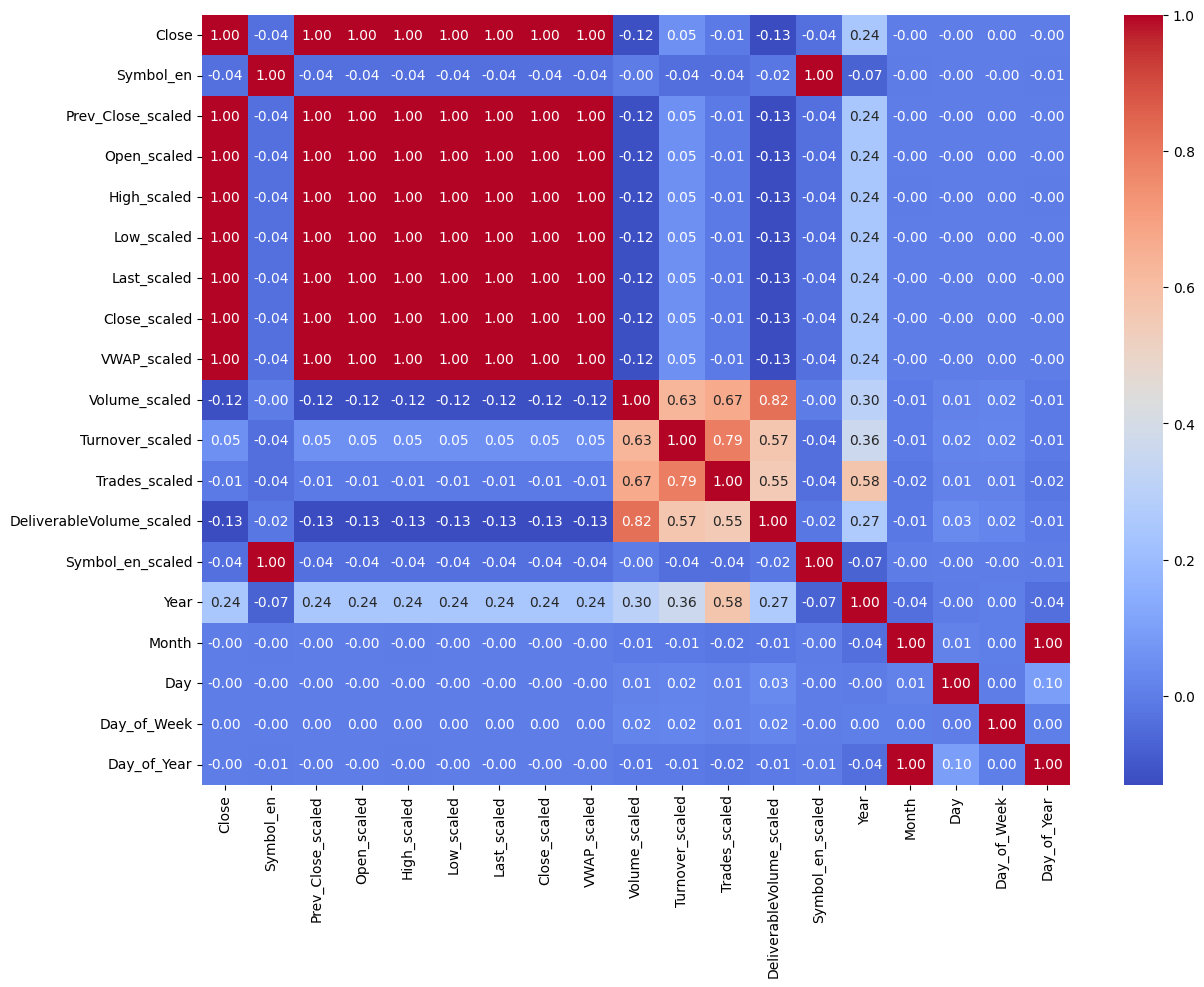

In [32]:
corr_df = clean_df.loc[:, ~clean_df.columns.isin(['Date', 'Symbol'])].corr('pearson')
plt.figure(figsize=(14, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [33]:
clean_df = clean_df.drop(axis=1, columns=['Close_scaled'])

In [34]:
csv_buffer = StringIO()
clean_df.to_csv(csv_buffer, index=False)

s3.put_object(
    Bucket='artificial-intelligence-datasets',
    Key='prepared/NIFTY50 Dataset/NIFTY50_prepared.csv',  # Your target path in the bucket
    Body=csv_buffer.getvalue()
)

{'ResponseMetadata': {'RequestId': 'W0C1V46TBK3DV2PD',
  'HostId': '47BGtpKQxThQWwxkeNMasdFXY9T60xnJ0L+8UuP4yM7dWxZyV+qLaCxfRcBbPfLDtkhh007L8zw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '47BGtpKQxThQWwxkeNMasdFXY9T60xnJ0L+8UuP4yM7dWxZyV+qLaCxfRcBbPfLDtkhh007L8zw=',
   'x-amz-request-id': 'W0C1V46TBK3DV2PD',
   'date': 'Sat, 10 May 2025 06:39:52 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"636ad7e180d3d9840c04023caa6d2324"',
   'x-amz-checksum-crc32': '4CZKqw==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"636ad7e180d3d9840c04023caa6d2324"',
 'ChecksumCRC32': '4CZKqw==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}